## Importing Packages and Loading the Data

In [1]:
# Importing necessary packages and libraries
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import cvxpy as cp

In [2]:
# Load the data from excel file
data = pd.read_excel('../multi_asset_etf_data.xlsx', sheet_name=3)

# Drop the 'QAI' column
data = data.drop(columns=['QAI'])

## Calculating Summary Statistics

In [3]:
# Calculate the mean monthly excess returns for each asset
mean_monthly_excess_returns = data.select_dtypes(include=[np.number]).mean()

# Calculate the standard deviation of the monthly returns for each asset
std_monthly_returns = data.select_dtypes(include=[np.number]).std()

# Calculating the monthly sharpe ratio of each asset
monthly_sharpe_ratio = mean_monthly_excess_returns / std_monthly_returns

# Calculating the annualized excess returns for each asset
annualized_excess_returns = mean_monthly_excess_returns * 12

# Calculating the annualized standard deviation for each asset
annualized_std_returns = std_monthly_returns * np.sqrt(12)

# Calculating the annualized sharpe ratio for each asset
annualized_sharpe_ratio = monthly_sharpe_ratio * np.sqrt(12)


In [4]:
# Summary Statistics
summary_stats = pd.DataFrame({
    'Mean Monthly Excess Returns': mean_monthly_excess_returns,
    'Standard Deviation of Monthly Returns': std_monthly_returns,
    'Annualized Excess Returns': annualized_excess_returns,
    'Annualized Standard Deviation': annualized_std_returns,
    'Annualized Sharpe Ratio': annualized_sharpe_ratio
})

summary_stats

,Mean Monthly Excess Returns,Standard Deviation of Monthly Returns,Annualized Excess Returns,Annualized Standard Deviation,Annualized Sharpe Ratio
BWX,-0.000643,0.023899,-0.007716,0.082789,-0.093202
DBC,-0.000441,0.048080,-0.005292,0.166553,-0.031774
EEM,0.002445,0.050854,0.029339,0.176164,0.166542
EFA,0.005148,0.043562,0.061775,0.150903,0.409372
HYG,0.003448,0.021918,0.041371,0.075928,0.544873
IEF,0.001367,0.018314,0.016404,0.063442,0.258569
IYR,0.006243,0.048692,0.074916,0.168675,0.444143
PSP,0.007713,0.061594,0.092561,0.213370,0.433804
SPY,0.010678,0.041234,0.128141,0.142839,0.897103
TIP,0.001708,0.014756,0.020502,0.051115,0.401091


## Calculating and Plotting Correlation Matrix

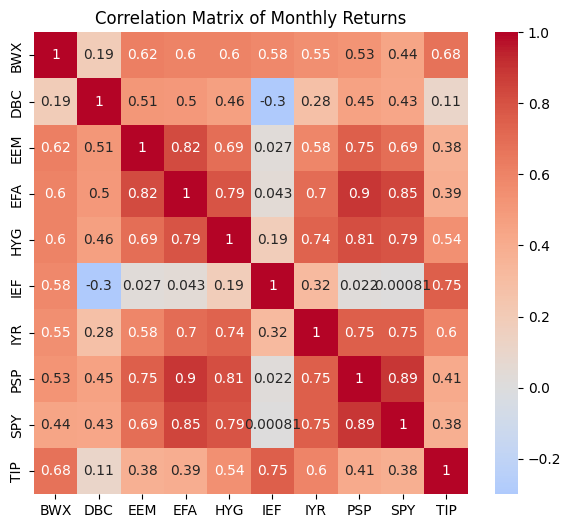

In [5]:
# Correlation Matrix for the returns
corr_mat = data.select_dtypes(include=[np.number]).corr()

# Visualizing the correlation matrix
plt.figure(figsize=(7, 6))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Monthly Returns')
plt.show()

#### The pair PSP and EFA has the highest correlation of ~ 0.90. The pair DBC and IEF has the lowest correlation of ~ -0.3

## Comparing TIPS to domestic bonds and foreign bonds

In [6]:
# Getting summary statistics for TIPS, domestic bonds, and foreign bonds
summary_stats.loc[['TIP', 'IEF', 'BWX'], ['Annualized Excess Returns', 'Annualized Sharpe Ratio']]

,Annualized Excess Returns,Annualized Sharpe Ratio
TIP,0.020502,0.401091
IEF,0.016404,0.258569
BWX,-0.007716,-0.093202


#### In our sample, TIPS (TIP) have delivered higher annualized excess returns and a superior risk-adjusted performance (as measured by the Sharpe ratio) compared to both domestic (IEF) and foreign (BWX) bonds.

## Getting optimal weights for the tangency portfolio

In [7]:
# Covariance matrix of the returns
cov_mat = data.select_dtypes(include=[np.number]).cov()

# Realized returns
mu = mean_monthly_excess_returns

# Converting mu and cov_mat to numpy arrays
mu_vec = mu.values
Sigma = cov_mat.values
ones = np.ones(len(mu_vec))

# Inverse covariance matrix
inv_Sigma = np.linalg.inv(Sigma)

# Calculating the tangency portfolio weights
w_tan = inv_Sigma @ mu_vec
w_tan = w_tan / (ones @ w_tan)

w_tan = pd.Series(w_tan, index=mu.index)
w_tan

BWX   -0.850643
DBC   -0.071623
EEM    0.026437
EFA    0.068682
HYG    0.290614
IEF    0.881186
IYR   -0.246582
PSP   -0.332995
SPY    1.059632
TIP    0.175293
dtype: float64

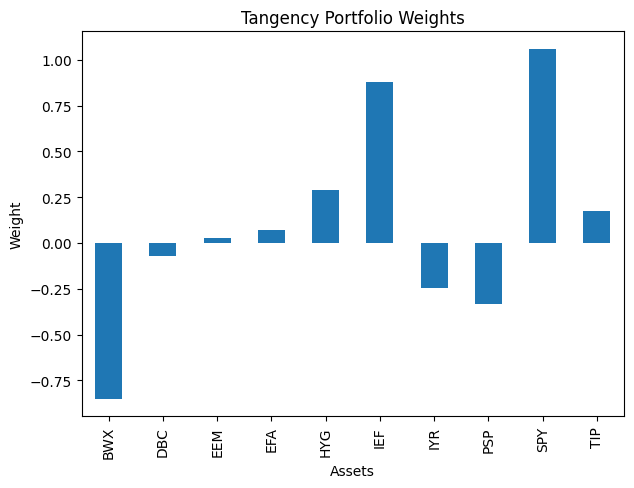

In [8]:
# Bar plot of the weights of the tangency portfolio
plt.figure(figsize=(7, 5))
w_tan.plot(kind='bar', ax=plt.gca())
plt.title('Tangency Portfolio Weights')
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.show()

## Plotting the Efficient Frontier

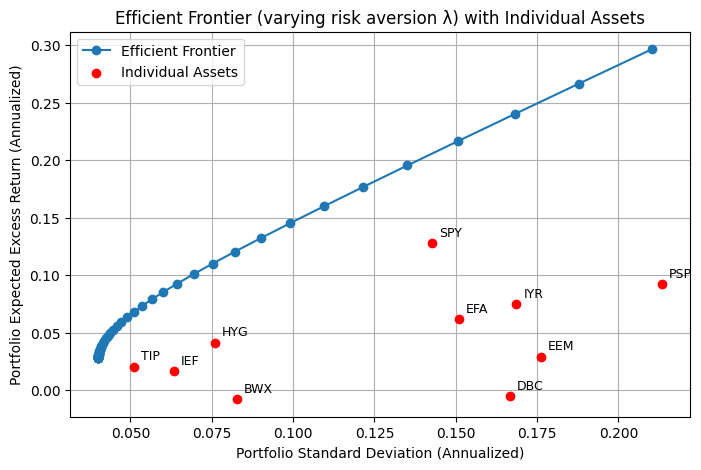

In [9]:
# Efficient frontier: plot portfolio expected excess return vs. standard deviation as a function of risk aversion (lambda)
n = len(mu)
lambdas = np.logspace(0.5, 3, 50)

portfolio_returns = []
portfolio_stds = []

for lambda_ in lambdas:
    # Set up the optimization variable for portfolio weights
    w = cp.Variable(n)
    # Maximize expected excess return minus lambda times portfolio variance
    objective = cp.Maximize(mu_vec @ w - lambda_ * cp.quad_form(w, Sigma))
    constraints = [cp.sum(w) == 1]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    w_opt = w.value
    if w_opt is not None:
        # Calculate portfolio expected excess return and standard deviation (annualized)
        port_return = (w_opt @ mu_vec) * 12
        port_std = np.sqrt(w_opt @ Sigma @ w_opt) * np.sqrt(12)
        portfolio_returns.append(port_return)
        portfolio_stds.append(port_std)
    else:
        portfolio_returns.append(np.nan)
        portfolio_stds.append(np.nan)

# Individual asset expected excess returns and volatilities (annualized)
asset_returns = mu_vec * 12
asset_stds = np.sqrt(np.diag(Sigma)) * np.sqrt(12)

plt.figure(figsize=(8, 5))
plt.plot(portfolio_stds, portfolio_returns, marker='o', label='Efficient Frontier')
plt.scatter(asset_stds, asset_returns, color='red', zorder=5, label='Individual Assets')
for i, asset in enumerate(mu.index):
    plt.annotate(asset, (asset_stds[i], asset_returns[i]), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9)

plt.xlabel('Portfolio Standard Deviation (Annualized)')
plt.ylabel('Portfolio Expected Excess Return (Annualized)')
plt.title('Efficient Frontier (varying risk aversion λ) with Individual Assets')
plt.legend()
plt.grid(True)
plt.show()

## Ranking of Tangency Portfolio Weights and Sharpe Ratio

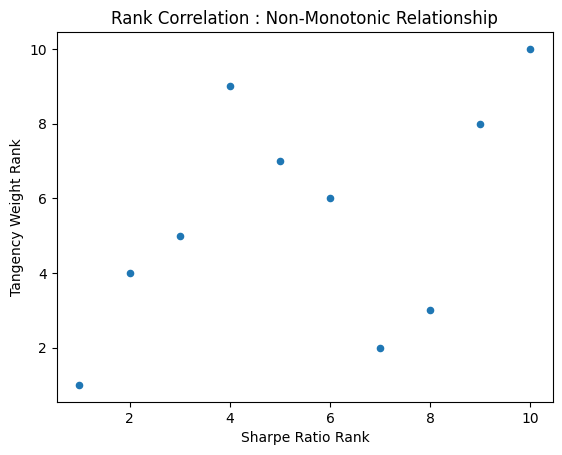

In [10]:
ranks = pd.DataFrame({
    'Sharpe Ratio Rank': annualized_sharpe_ratio.rank(),
    'Tangency Weight Rank': w_tan.rank()
})
ax = ranks.plot(kind='scatter', x='Sharpe Ratio Rank', y='Tangency Weight Rank')
ax.set_xlabel('Sharpe Ratio Rank')
ax.set_ylabel('Tangency Weight Rank')
ax.set_title('Rank Correlation : Non-Monotonic Relationship')
plt.show()

#### No, the ranking of the weights does not align with the Sharpe ratio and is not monotonic

## Computing the Mean, Volatility and Sharpe Ratio for the Tangency Portfolio

In [11]:
mean_tan = (w_tan @ mu_vec) * 12
vol_tan = np.sqrt(w_tan @ Sigma @ w_tan) * np.sqrt(12)
sharpe_tan = mean_tan / vol_tan

tan_portfolio_stats = pd.DataFrame({
    'Mean': [mean_tan],
    'Volatility': [vol_tan],
    'Sharpe Ratio': [sharpe_tan]
}, index=['Tangency Portfolio'])

tan_portfolio_stats = tan_portfolio_stats.round(2)
tan_portfolio_stats


,Mean,Volatility,Sharpe Ratio
Tangency Portfolio,0.13,0.09,1.47


## Tangency Portfolio Without TIPS

In [12]:
# Covariance matrix of the returns without TIP
cov_mat_without_TIP = data.select_dtypes(include=[np.number]).drop(columns=['TIP']).cov()

# Realized returns without TIP
mu_without_TIP = mean_monthly_excess_returns.drop(index=['TIP'])

# Converting mu_without_TIP and cov_mat_without_TIP to numpy arrays
mu_vec_without_TIP = mu_without_TIP.values
Sigma_without_TIP = cov_mat_without_TIP.values
ones = np.ones(len(mu_vec_without_TIP))

# Inverse covariance matrix without TIP
inv_Sigma_without_TIP = np.linalg.inv(Sigma_without_TIP)

# Calculating the tangency portfolio weights without TIP
w_tan_without_TIP = inv_Sigma_without_TIP @ mu_vec_without_TIP
w_tan_without_TIP = w_tan_without_TIP / (ones @ w_tan_without_TIP)

w_tan_without_TIP = pd.Series(w_tan_without_TIP, index=mu_without_TIP.index)
w_tan_without_TIP

BWX   -0.879292
DBC   -0.063742
EEM    0.032493
EFA    0.060153
HYG    0.316300
IEF    1.019957
IYR   -0.247445
PSP   -0.339398
SPY    1.100973
dtype: float64

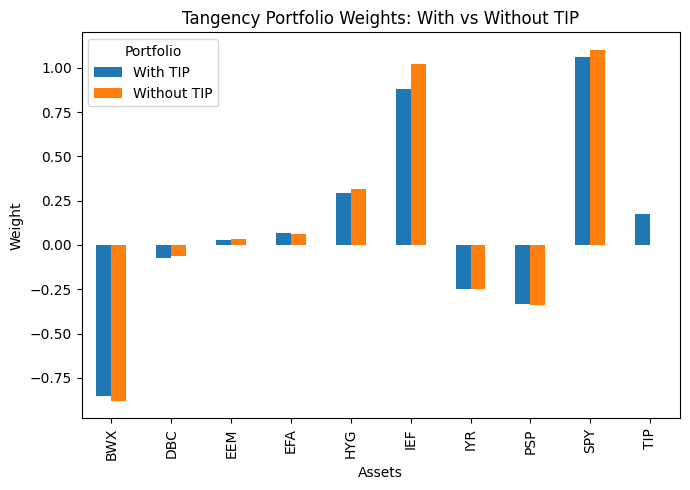

In [13]:
# Bar plot comparing the weights of the tangency portfolio with and without TIP
plt.figure(figsize=(7, 5))
weights_df = pd.DataFrame({
    'With TIP': w_tan,
    'Without TIP': w_tan_without_TIP
})
weights_df.plot(kind='bar', ax=plt.gca())
plt.title('Tangency Portfolio Weights: With vs Without TIP')
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.legend(title='Portfolio')
plt.tight_layout()
plt.show()

In [14]:
mean_tan_without_TIP = (w_tan_without_TIP @ mu_vec_without_TIP) * 12
vol_tan_without_TIP = np.sqrt(w_tan_without_TIP @ Sigma_without_TIP @ w_tan_without_TIP) * np.sqrt(12)
sharpe_tan_without_TIP = mean_tan_without_TIP / vol_tan_without_TIP

tan_portfolio_stats_without_TIP = pd.DataFrame({
    'Mean': [mean_tan_without_TIP],
    'Volatility': [vol_tan_without_TIP],
    'Sharpe Ratio': [sharpe_tan_without_TIP]
}, index=['Tangency Portfolio (without TIP)'])

tan_portfolio_stats_without_TIP = tan_portfolio_stats_without_TIP.round(2)
tan_portfolio_stats_without_TIP


,Mean,Volatility,Sharpe Ratio
Tangency Portfolio (without TIP),0.13,0.09,1.47


#### Excluding TIPS from the portfolio has minimal effect on both the asset weights and overall performance metrics.

In [15]:
# Adjusting the TIP to be 0.0012 higher than what the historic sample suggests
tip_adjusted_data = data.copy()
tip_adjusted_data['TIP'] = tip_adjusted_data['TIP'] + (0.0012)
tip_adjusted_mu = tip_adjusted_data.select_dtypes(include=[np.number]).mean()

# Converting tip_adjusted_mu and cov_mat to numpy arrays
tip_adjusted_mu_vec = tip_adjusted_mu.values
Sigma_tip_adjusted = cov_mat.values
ones = np.ones(len(tip_adjusted_mu_vec))

# Inverse covariance matrix
inv_Sigma_tip_adjusted = np.linalg.inv(Sigma_tip_adjusted)

# Calculating the tangency portfolio weights
w_tan_tip_adjusted = inv_Sigma_tip_adjusted @ tip_adjusted_mu_vec
w_tan_tip_adjusted = w_tan_tip_adjusted / (ones @ w_tan_tip_adjusted)

w_tan_tip_adjusted = pd.Series(w_tan_tip_adjusted, index=tip_adjusted_mu.index)
w_tan_tip_adjusted

BWX   -0.669693
DBC   -0.121397
EEM   -0.011815
EFA    0.122554
HYG    0.128372
IEF    0.004667
IYR   -0.241132
PSP   -0.292555
SPY    0.798513
TIP    1.282487
dtype: float64

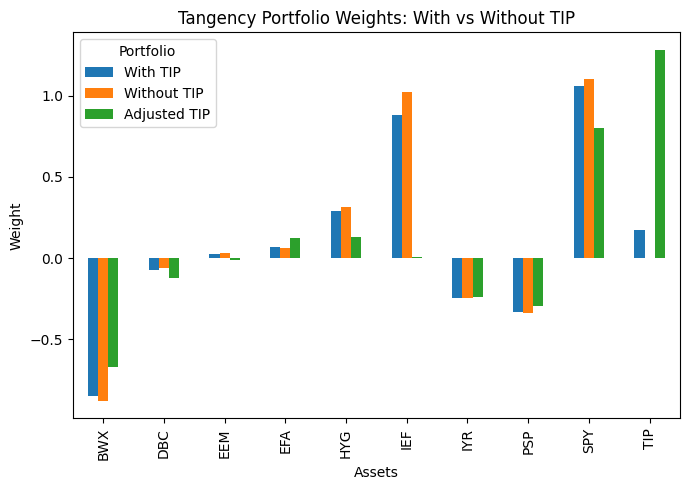

In [16]:
# Bar plot comparing the weights of the tangency portfolio with and without TIP and adjusted TIP
plt.figure(figsize=(7, 5))
weights_df = pd.DataFrame({
    'With TIP': w_tan,
    'Without TIP': w_tan_without_TIP,
    'Adjusted TIP': w_tan_tip_adjusted
})
weights_df.plot(kind='bar', ax=plt.gca())
plt.title('Tangency Portfolio Weights: With vs Without TIP')
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.legend(title='Portfolio')
plt.tight_layout()
plt.show()

In [17]:
mean_tan_tip_adjusted = (w_tan_tip_adjusted @ tip_adjusted_mu_vec) * 12
vol_tan_tip_adjusted = np.sqrt(w_tan_tip_adjusted @ Sigma_tip_adjusted @ w_tan_tip_adjusted) * np.sqrt(12)
sharpe_tan_tip_adjusted = mean_tan_tip_adjusted / vol_tan_tip_adjusted

tan_portfolio_stats_tip_adjusted = pd.DataFrame({
    'Mean': [mean_tan_tip_adjusted],
    'Volatility': [vol_tan_tip_adjusted],
    'Sharpe Ratio': [sharpe_tan_tip_adjusted]
}, index=['Tangency Portfolio (TIP Adjusted)'])

tan_portfolio_stats_tip_adjusted = tan_portfolio_stats_tip_adjusted.round(5)
tan_portfolio_stats_tip_adjusted

,Mean,Volatility,Sharpe Ratio
Tangency Portfolio (TIP Adjusted),0.12036,0.07465,1.6124


#### Although dropping TIPS did not significantly affect the portfolio weights or performance, including TIPS which performed slightly better (0.0012, or approximately 1.44% better annually) did improve the Sharpe ratio of the portfolio from 1.47 to 1.61. This suggests that TIPS do help expand the investment opportunity set.

## Comparing different weighting schemes

In [18]:
weights_equal = mean_monthly_excess_returns*0 + (1/len(mean_monthly_excess_returns))
weights_risk_parity = 1/(std_monthly_returns**2)
weights_tan = w_tan

target_mean_return = 0.01

scaling_factor_equal = target_mean_return/(weights_equal @ mu_vec)
scaling_factor_risk_parity = target_mean_return/(weights_risk_parity @ mu_vec)
scaling_factor_tan = target_mean_return/(weights_tan @ mu_vec)

scaled_weights_equal = scaling_factor_equal * weights_equal
scaled_weights_risk_parity = scaling_factor_risk_parity * weights_risk_parity
scaled_weights_tan = scaling_factor_tan * weights_tan

In [19]:
# Summary Statistics for the different weighting schemes (annualized)
schemes = {
    'Equal Weighting': (scaling_factor_equal * weights_equal),
    'Risk Parity': (scaling_factor_risk_parity * weights_risk_parity),
    'Tangency': (scaling_factor_tan * weights_tan)
}

summary_stats = pd.DataFrame(
    {
        'Mean': [12 * (w @ mu_vec) for w in schemes.values()],
        'Volatility': [np.sqrt(12) * np.sqrt(w @ Sigma @ w) for w in schemes.values()],
        'Sharpe Ratio': [
            (12 * (w @ mu_vec)) / (np.sqrt(12) * np.sqrt(w @ Sigma @ w)) for w in schemes.values()
        ]
    },
    index=schemes.keys()
)
summary_stats = summary_stats.round(5)
summary_stats

,Mean,Volatility,Sharpe Ratio
Equal Weighting,0.12,0.26925,0.44569
Risk Parity,0.12,0.26392,0.45469
Tangency,0.12,0.08168,1.46919


#### The Tangency portfolio achieves the highest Sharpe ratio, indicating the best risk-adjusted performance among the three. This is expected, as the tangency portfolio is constructed to maximize the Sharpe ratio given the inputs. The Risk Parity approach typically results in lower volatility than Equal Weighting, as it allocates more to assets with lower risk, but its Sharpe ratio may be lower than the Tangency portfolio if it does not fully take into account the return differences. Equal Weighting provides a simple benchmark, but generally has lower risk-adjusted returns compared to the optimized methods.

#### In summary, the Tangency portfolio outperforms the other methods in terms of risk-adjusted return, while Risk Parity offers a balance between risk and return, and Equal Weighting serves as a straightforward, but less efficient, allocation.
